rework of ch_9_2_first_nns.ipnynb to make cnns  
utilizing csv instead of loading as images   
5. 15x20 // CNN 1D // 3 - Live Data vs PerfectFam vs StreakMM

# IMPORTS

In [4]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [5]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [10]:
df_alldata = pd.read_csv('combined_dataset.csv')
# display(df_alldata)

In [11]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [15]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [18]:
orig_labels = list(df_w_live['labels'])

In [19]:
len(orig_labels)

132127

In [20]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [28]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [31]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [33]:
df_w_live['labels'] = replaced_labels

In [35]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [41]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [43]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [45]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [46]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [49]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [51]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [53]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


# Create Pytorch Dataset (custom)

## Define Dataset Class

In [58]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [62]:
all_dataset = RecordsDataset(df_w_live)

## Split Train & Test

In [66]:
train_size = int(0.7 * len(all_dataset))
test_size = len(all_dataset) - train_size
# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(12))
### torch.Generator().manual_seed(42)

In [68]:
train_alldataset
len(train_alldataset)

92488

In [70]:
test_alldataset
len(test_alldataset)

39639

## Create Train & Test all_dataloaders

In [74]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [76]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [80]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

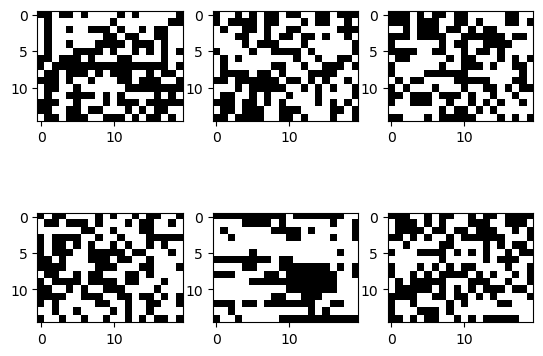

In [82]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [84]:
print(example_targets)

tensor([1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2,
        0, 1, 1, 1, 0, 1, 0, 1])


### Check Test alldataloader

In [88]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

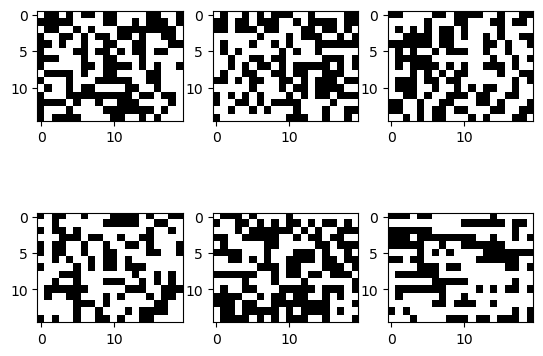

In [90]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [92]:
print(example_targets)

tensor([0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 2,
        1, 1, 1, 0, 1, 0, 1, 1])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [375]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
# num_epochs = 50
# num_epochs = 100
# num_epochs = 300
num_epochs = 500
# num_epochs = 1000

learning_rate = 0.0003

In [376]:
print(device)

mps


## Define Model

In [378]:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
        # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
        # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
        self.fc1 = nn.Linear(16*18, 64)
        # self.fc2 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop1 = nn.Dropout(p=0.3)
        # self.drop2 = nn.Dropout(p=0.3)
        
        ### crossentropyloss already entails softmax -> softmax not needed additionally
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(f'{x.shape}')       # batch_size, 300
        
        x = x.reshape(-1, 1, 300)
        # print(x.shape)      # batch_size, 1, 300
        
        x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 256, 150
        # print(x.shape)
        x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 128, 75
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 37
        # print(x.shape)
        x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 18
        # print(x.shape)
        x = F.relu(self.conv5(x))   # -> batch_size, 32, 18
        # print(x.shape)

        
        x = torch.flatten(x, 1)     # -> batch_size, 288
        # print(x.shape)
        x = self.drop1(x)
        
        x = F.relu(self.fc1(x))     # -> batch_size, 64
        x = self.drop1(x)
        # print(x.shape)
        
        x = self.fc2(x)             # -> batch_size, num_classes(=3)
        # print(x.shape)
    
        
        return x
    
    
    
#######################    
# torch.Size([32, 300])
# torch.Size([32, 1, 300])
# torch.Size([32, 256, 300])
# torch.Size([32, 256, 150])
# torch.Size([32, 128, 150])
# torch.Size([32, 128, 75])
# torch.Size([32, 64, 75])
# torch.Size([32, 64, 37])
# torch.Size([32, 32, 37])
# torch.Size([32, 32, 18])
# torch.Size([32, 16, 18])
# torch.Size([32, 288])
# torch.Size([32, 64])
# torch.Size([32, 3])


### 10 epochs // initial loss: 0.555, final loss:  // 14s per epoch
### 50 epochs // initial loss: , final loss:  // 14s per epoch
### 100 epochs // initial loss: , final loss:   // 
### 300 epochs // initial loss: , final loss:   // 
### 500 epochs // initial loss: , final loss:   // 


## Train First CNN

In [380]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))








2024-05-21 19:31:23




  0%|          | 1/500 [00:12<1:45:54, 12.73s/it]

[1] loss: 0.551


  0%|          | 2/500 [00:25<1:43:48, 12.51s/it]

[2] loss: 0.520


  1%|          | 3/500 [00:37<1:44:13, 12.58s/it]

[3] loss: 0.514


  1%|          | 4/500 [00:50<1:43:29, 12.52s/it]

[4] loss: 0.507


  1%|          | 5/500 [01:02<1:44:05, 12.62s/it]

[5] loss: 0.504


  1%|          | 6/500 [01:15<1:43:46, 12.60s/it]

[6] loss: 0.502


  1%|▏         | 7/500 [01:28<1:43:10, 12.56s/it]

[7] loss: 0.500


  2%|▏         | 8/500 [01:40<1:42:59, 12.56s/it]

[8] loss: 0.498


  2%|▏         | 9/500 [01:52<1:42:20, 12.51s/it]

[9] loss: 0.497


  2%|▏         | 10/500 [02:05<1:42:45, 12.58s/it]

[10] loss: 0.495


  2%|▏         | 11/500 [02:18<1:42:08, 12.53s/it]

[11] loss: 0.493


  2%|▏         | 12/500 [02:30<1:41:46, 12.51s/it]

[12] loss: 0.491


  3%|▎         | 13/500 [02:43<1:41:31, 12.51s/it]

[13] loss: 0.490


  3%|▎         | 14/500 [02:55<1:41:09, 12.49s/it]

[14] loss: 0.488


  3%|▎         | 15/500 [03:08<1:41:31, 12.56s/it]

[15] loss: 0.486


  3%|▎         | 16/500 [03:20<1:41:20, 12.56s/it]

[16] loss: 0.482


  3%|▎         | 17/500 [03:33<1:41:22, 12.59s/it]

[17] loss: 0.480


  4%|▎         | 18/500 [03:45<1:40:48, 12.55s/it]

[18] loss: 0.476


  4%|▍         | 19/500 [03:58<1:40:22, 12.52s/it]

[19] loss: 0.473


  4%|▍         | 20/500 [04:11<1:40:49, 12.60s/it]

[20] loss: 0.469


  4%|▍         | 21/500 [04:23<1:40:02, 12.53s/it]

[21] loss: 0.465


  4%|▍         | 22/500 [04:36<1:39:55, 12.54s/it]

[22] loss: 0.462


  5%|▍         | 23/500 [04:48<1:39:37, 12.53s/it]

[23] loss: 0.457


  5%|▍         | 24/500 [05:01<1:39:48, 12.58s/it]

[24] loss: 0.453


  5%|▌         | 25/500 [05:13<1:39:32, 12.57s/it]

[25] loss: 0.449


  5%|▌         | 26/500 [05:26<1:39:08, 12.55s/it]

[26] loss: 0.447


  5%|▌         | 27/500 [05:38<1:38:46, 12.53s/it]

[27] loss: 0.441


  6%|▌         | 28/500 [05:51<1:38:13, 12.49s/it]

[28] loss: 0.437


  6%|▌         | 29/500 [06:03<1:38:28, 12.54s/it]

[29] loss: 0.432


  6%|▌         | 30/500 [06:16<1:38:12, 12.54s/it]

[30] loss: 0.428


  6%|▌         | 31/500 [06:29<1:39:58, 12.79s/it]

[31] loss: 0.425


  6%|▋         | 32/500 [06:48<1:52:44, 14.45s/it]

[32] loss: 0.420


  7%|▋         | 33/500 [07:08<2:05:05, 16.07s/it]

[33] loss: 0.417


  7%|▋         | 34/500 [07:27<2:12:10, 17.02s/it]

[34] loss: 0.411


  7%|▋         | 35/500 [07:47<2:19:26, 17.99s/it]

[35] loss: 0.408


  7%|▋         | 36/500 [08:06<2:22:03, 18.37s/it]

[36] loss: 0.404


  7%|▋         | 37/500 [08:25<2:22:17, 18.44s/it]

[37] loss: 0.400


  8%|▊         | 38/500 [08:43<2:22:26, 18.50s/it]

[38] loss: 0.396


  8%|▊         | 39/500 [09:02<2:21:56, 18.47s/it]

[39] loss: 0.393


  8%|▊         | 40/500 [09:20<2:21:40, 18.48s/it]

[40] loss: 0.391


  8%|▊         | 41/500 [09:39<2:20:50, 18.41s/it]

[41] loss: 0.388


  8%|▊         | 42/500 [09:57<2:20:06, 18.36s/it]

[42] loss: 0.384


  9%|▊         | 43/500 [10:15<2:20:14, 18.41s/it]

[43] loss: 0.379


  9%|▉         | 44/500 [10:34<2:19:41, 18.38s/it]

[44] loss: 0.378


  9%|▉         | 45/500 [10:52<2:18:54, 18.32s/it]

[45] loss: 0.375


  9%|▉         | 46/500 [11:10<2:18:38, 18.32s/it]

[46] loss: 0.372


  9%|▉         | 47/500 [11:29<2:18:22, 18.33s/it]

[47] loss: 0.370


 10%|▉         | 48/500 [11:47<2:17:41, 18.28s/it]

[48] loss: 0.367


 10%|▉         | 49/500 [12:05<2:17:28, 18.29s/it]

[49] loss: 0.364


 10%|█         | 50/500 [12:23<2:17:14, 18.30s/it]

[50] loss: 0.361


 10%|█         | 51/500 [12:42<2:17:03, 18.32s/it]

[51] loss: 0.359


 10%|█         | 52/500 [13:00<2:16:56, 18.34s/it]

[52] loss: 0.358


 11%|█         | 53/500 [13:18<2:16:20, 18.30s/it]

[53] loss: 0.354


 11%|█         | 54/500 [13:37<2:16:26, 18.35s/it]

[54] loss: 0.354


 11%|█         | 55/500 [13:55<2:15:42, 18.30s/it]

[55] loss: 0.349


 11%|█         | 56/500 [14:13<2:15:43, 18.34s/it]

[56] loss: 0.347


 11%|█▏        | 57/500 [14:32<2:15:12, 18.31s/it]

[57] loss: 0.345


 12%|█▏        | 58/500 [14:50<2:14:50, 18.30s/it]

[58] loss: 0.343


 12%|█▏        | 59/500 [15:09<2:15:06, 18.38s/it]

[59] loss: 0.342


 12%|█▏        | 60/500 [15:27<2:14:36, 18.36s/it]

[60] loss: 0.338


 12%|█▏        | 61/500 [15:45<2:13:52, 18.30s/it]

[61] loss: 0.337


 12%|█▏        | 62/500 [16:03<2:13:38, 18.31s/it]

[62] loss: 0.335


 13%|█▎        | 63/500 [16:22<2:13:15, 18.30s/it]

[63] loss: 0.332


 13%|█▎        | 64/500 [16:40<2:12:48, 18.28s/it]

[64] loss: 0.333


 13%|█▎        | 65/500 [16:58<2:12:14, 18.24s/it]

[65] loss: 0.329


 13%|█▎        | 66/500 [17:16<2:12:11, 18.28s/it]

[66] loss: 0.326


 13%|█▎        | 67/500 [17:35<2:12:00, 18.29s/it]

[67] loss: 0.324


 14%|█▎        | 68/500 [17:53<2:11:21, 18.24s/it]

[68] loss: 0.322


 14%|█▍        | 69/500 [18:11<2:11:44, 18.34s/it]

[69] loss: 0.322


 14%|█▍        | 70/500 [18:30<2:11:03, 18.29s/it]

[70] loss: 0.320


 14%|█▍        | 71/500 [18:48<2:10:37, 18.27s/it]

[71] loss: 0.319


 14%|█▍        | 72/500 [19:06<2:11:06, 18.38s/it]

[72] loss: 0.317


 15%|█▍        | 73/500 [19:25<2:10:38, 18.36s/it]

[73] loss: 0.314


 15%|█▍        | 74/500 [19:43<2:09:50, 18.29s/it]

[74] loss: 0.312


 15%|█▌        | 75/500 [20:01<2:09:34, 18.29s/it]

[75] loss: 0.310


 15%|█▌        | 76/500 [20:19<2:09:05, 18.27s/it]

[76] loss: 0.309


 15%|█▌        | 77/500 [20:38<2:08:56, 18.29s/it]

[77] loss: 0.307


 16%|█▌        | 78/500 [20:56<2:08:24, 18.26s/it]

[78] loss: 0.306


 16%|█▌        | 79/500 [21:14<2:08:20, 18.29s/it]

[79] loss: 0.303


 16%|█▌        | 80/500 [21:33<2:08:03, 18.29s/it]

[80] loss: 0.301


 16%|█▌        | 81/500 [21:51<2:07:18, 18.23s/it]

[81] loss: 0.301


 16%|█▋        | 82/500 [22:09<2:07:40, 18.33s/it]

[82] loss: 0.296


 17%|█▋        | 83/500 [22:27<2:07:06, 18.29s/it]

[83] loss: 0.299


 17%|█▋        | 84/500 [22:45<2:06:01, 18.18s/it]

[84] loss: 0.296


 17%|█▋        | 85/500 [23:04<2:06:09, 18.24s/it]

[85] loss: 0.295


 17%|█▋        | 86/500 [23:22<2:06:34, 18.34s/it]

[86] loss: 0.294


 17%|█▋        | 87/500 [23:41<2:06:37, 18.40s/it]

[87] loss: 0.291


 18%|█▊        | 88/500 [23:59<2:06:03, 18.36s/it]

[88] loss: 0.289


 18%|█▊        | 89/500 [24:17<2:05:49, 18.37s/it]

[89] loss: 0.290


 18%|█▊        | 90/500 [24:36<2:05:19, 18.34s/it]

[90] loss: 0.287


 18%|█▊        | 91/500 [24:54<2:04:54, 18.32s/it]

[91] loss: 0.284


 18%|█▊        | 92/500 [25:12<2:04:48, 18.35s/it]

[92] loss: 0.285


 19%|█▊        | 93/500 [25:31<2:04:31, 18.36s/it]

[93] loss: 0.285


 19%|█▉        | 94/500 [25:49<2:03:51, 18.30s/it]

[94] loss: 0.283


 19%|█▉        | 95/500 [26:07<2:03:54, 18.36s/it]

[95] loss: 0.282


 19%|█▉        | 96/500 [26:26<2:03:21, 18.32s/it]

[96] loss: 0.279


 19%|█▉        | 97/500 [26:45<2:04:22, 18.52s/it]

[97] loss: 0.277


 20%|█▉        | 98/500 [27:04<2:05:31, 18.74s/it]

[98] loss: 0.274


 20%|█▉        | 99/500 [27:24<2:07:43, 19.11s/it]

[99] loss: 0.275


 20%|██        | 100/500 [27:43<2:08:02, 19.21s/it]

[100] loss: 0.276


 20%|██        | 101/500 [28:03<2:08:21, 19.30s/it]

[101] loss: 0.273


 20%|██        | 102/500 [28:22<2:08:11, 19.33s/it]

[102] loss: 0.274


 21%|██        | 103/500 [28:42<2:08:51, 19.47s/it]

[103] loss: 0.272


 21%|██        | 104/500 [29:02<2:08:46, 19.51s/it]

[104] loss: 0.271


 21%|██        | 105/500 [29:21<2:08:39, 19.54s/it]

[105] loss: 0.267


 21%|██        | 106/500 [29:40<2:05:53, 19.17s/it]

[106] loss: 0.268


 21%|██▏       | 107/500 [29:58<2:03:37, 18.87s/it]

[107] loss: 0.266


 22%|██▏       | 108/500 [30:16<2:02:05, 18.69s/it]

[108] loss: 0.266


 22%|██▏       | 109/500 [30:35<2:02:50, 18.85s/it]

[109] loss: 0.263


 22%|██▏       | 110/500 [30:54<2:01:27, 18.69s/it]

[110] loss: 0.261


 22%|██▏       | 111/500 [31:13<2:02:29, 18.89s/it]

[111] loss: 0.262


 22%|██▏       | 112/500 [31:32<2:01:42, 18.82s/it]

[112] loss: 0.261


 23%|██▎       | 113/500 [31:50<2:00:30, 18.68s/it]

[113] loss: 0.260


 23%|██▎       | 114/500 [32:08<1:59:44, 18.61s/it]

[114] loss: 0.260


 23%|██▎       | 115/500 [32:27<1:58:50, 18.52s/it]

[115] loss: 0.258


 23%|██▎       | 116/500 [32:45<1:58:18, 18.49s/it]

[116] loss: 0.257


 23%|██▎       | 117/500 [33:03<1:57:32, 18.41s/it]

[117] loss: 0.257


 24%|██▎       | 118/500 [33:22<1:56:56, 18.37s/it]

[118] loss: 0.256


 24%|██▍       | 119/500 [33:40<1:56:44, 18.38s/it]

[119] loss: 0.255


 24%|██▍       | 120/500 [33:58<1:56:04, 18.33s/it]

[120] loss: 0.251


 24%|██▍       | 121/500 [34:16<1:55:32, 18.29s/it]

[121] loss: 0.253


 24%|██▍       | 122/500 [34:35<1:55:14, 18.29s/it]

[122] loss: 0.251


 25%|██▍       | 123/500 [34:53<1:54:50, 18.28s/it]

[123] loss: 0.252


 25%|██▍       | 124/500 [35:11<1:54:35, 18.29s/it]

[124] loss: 0.247


 25%|██▌       | 125/500 [35:30<1:54:29, 18.32s/it]

[125] loss: 0.250


 25%|██▌       | 126/500 [35:48<1:53:56, 18.28s/it]

[126] loss: 0.249


 25%|██▌       | 127/500 [36:06<1:53:40, 18.29s/it]

[127] loss: 0.248


 26%|██▌       | 128/500 [36:24<1:53:13, 18.26s/it]

[128] loss: 0.245


 26%|██▌       | 129/500 [36:43<1:53:08, 18.30s/it]

[129] loss: 0.246


 26%|██▌       | 130/500 [37:01<1:52:46, 18.29s/it]

[130] loss: 0.242


 26%|██▌       | 131/500 [37:19<1:52:25, 18.28s/it]

[131] loss: 0.243


 26%|██▋       | 132/500 [37:38<1:52:21, 18.32s/it]

[132] loss: 0.243


 27%|██▋       | 133/500 [37:56<1:52:03, 18.32s/it]

[133] loss: 0.241


 27%|██▋       | 134/500 [38:14<1:51:43, 18.32s/it]

[134] loss: 0.240


 27%|██▋       | 135/500 [38:33<1:51:31, 18.33s/it]

[135] loss: 0.240


 27%|██▋       | 136/500 [38:51<1:50:55, 18.29s/it]

[136] loss: 0.238


 27%|██▋       | 137/500 [39:09<1:50:50, 18.32s/it]

[137] loss: 0.238


 28%|██▊       | 138/500 [39:28<1:50:29, 18.31s/it]

[138] loss: 0.238


 28%|██▊       | 139/500 [39:46<1:50:08, 18.31s/it]

[139] loss: 0.235


 28%|██▊       | 140/500 [40:04<1:49:54, 18.32s/it]

[140] loss: 0.234


 28%|██▊       | 141/500 [40:23<1:49:48, 18.35s/it]

[141] loss: 0.234


 28%|██▊       | 142/500 [40:41<1:49:42, 18.39s/it]

[142] loss: 0.236


 29%|██▊       | 143/500 [40:59<1:49:14, 18.36s/it]

[143] loss: 0.232


 29%|██▉       | 144/500 [41:18<1:48:50, 18.34s/it]

[144] loss: 0.234


 29%|██▉       | 145/500 [41:36<1:48:49, 18.39s/it]

[145] loss: 0.231


 29%|██▉       | 146/500 [41:55<1:48:39, 18.42s/it]

[146] loss: 0.232


 29%|██▉       | 147/500 [42:14<1:50:38, 18.81s/it]

[147] loss: 0.229


 30%|██▉       | 148/500 [42:34<1:51:34, 19.02s/it]

[148] loss: 0.230


 30%|██▉       | 149/500 [42:54<1:52:34, 19.24s/it]

[149] loss: 0.228


 30%|███       | 150/500 [43:12<1:50:44, 18.98s/it]

[150] loss: 0.225


 30%|███       | 151/500 [43:31<1:49:40, 18.85s/it]

[151] loss: 0.224


 30%|███       | 152/500 [43:49<1:48:22, 18.69s/it]

[152] loss: 0.227


 31%|███       | 153/500 [44:07<1:47:35, 18.60s/it]

[153] loss: 0.224


 31%|███       | 154/500 [44:25<1:46:36, 18.49s/it]

[154] loss: 0.225


 31%|███       | 155/500 [44:44<1:46:09, 18.46s/it]

[155] loss: 0.224


 31%|███       | 156/500 [45:02<1:45:33, 18.41s/it]

[156] loss: 0.223


 31%|███▏      | 157/500 [45:21<1:45:09, 18.39s/it]

[157] loss: 0.222


 32%|███▏      | 158/500 [45:39<1:44:40, 18.36s/it]

[158] loss: 0.223


 32%|███▏      | 159/500 [45:57<1:44:01, 18.30s/it]

[159] loss: 0.222


 32%|███▏      | 160/500 [46:15<1:43:53, 18.33s/it]

[160] loss: 0.219


 32%|███▏      | 161/500 [46:34<1:43:21, 18.29s/it]

[161] loss: 0.218


 32%|███▏      | 162/500 [46:52<1:43:01, 18.29s/it]

[162] loss: 0.219


 33%|███▎      | 163/500 [47:10<1:43:15, 18.39s/it]

[163] loss: 0.218


 33%|███▎      | 164/500 [47:29<1:42:44, 18.35s/it]

[164] loss: 0.219


 33%|███▎      | 165/500 [47:47<1:42:11, 18.30s/it]

[165] loss: 0.217


 33%|███▎      | 166/500 [48:05<1:42:13, 18.36s/it]

[166] loss: 0.216


 33%|███▎      | 167/500 [48:24<1:41:46, 18.34s/it]

[167] loss: 0.216


 34%|███▎      | 168/500 [48:42<1:41:19, 18.31s/it]

[168] loss: 0.215


 34%|███▍      | 169/500 [49:00<1:41:05, 18.33s/it]

[169] loss: 0.212


 34%|███▍      | 170/500 [49:19<1:40:33, 18.28s/it]

[170] loss: 0.213


 34%|███▍      | 171/500 [49:37<1:40:39, 18.36s/it]

[171] loss: 0.213


 34%|███▍      | 172/500 [49:56<1:41:47, 18.62s/it]

[172] loss: 0.214


 35%|███▍      | 173/500 [50:15<1:41:56, 18.70s/it]

[173] loss: 0.212


 35%|███▍      | 174/500 [50:34<1:41:36, 18.70s/it]

[174] loss: 0.211


 35%|███▌      | 175/500 [50:53<1:41:36, 18.76s/it]

[175] loss: 0.210


 35%|███▌      | 176/500 [51:12<1:41:46, 18.85s/it]

[176] loss: 0.212


 35%|███▌      | 177/500 [51:30<1:40:46, 18.72s/it]

[177] loss: 0.210


 36%|███▌      | 178/500 [51:49<1:39:48, 18.60s/it]

[178] loss: 0.208


 36%|███▌      | 179/500 [52:07<1:39:14, 18.55s/it]

[179] loss: 0.207


 36%|███▌      | 180/500 [52:25<1:38:22, 18.44s/it]

[180] loss: 0.206


 36%|███▌      | 181/500 [52:44<1:38:03, 18.45s/it]

[181] loss: 0.204


 36%|███▋      | 182/500 [53:02<1:37:17, 18.36s/it]

[182] loss: 0.206


 37%|███▋      | 183/500 [53:20<1:36:51, 18.33s/it]

[183] loss: 0.206


 37%|███▋      | 184/500 [53:38<1:36:31, 18.33s/it]

[184] loss: 0.206


 37%|███▋      | 185/500 [53:57<1:35:59, 18.28s/it]

[185] loss: 0.206


 37%|███▋      | 186/500 [54:15<1:35:37, 18.27s/it]

[186] loss: 0.205


 37%|███▋      | 187/500 [54:33<1:35:26, 18.29s/it]

[187] loss: 0.202


 38%|███▊      | 188/500 [54:51<1:35:07, 18.29s/it]

[188] loss: 0.203


 38%|███▊      | 189/500 [55:10<1:34:40, 18.27s/it]

[189] loss: 0.202


 38%|███▊      | 190/500 [55:28<1:34:17, 18.25s/it]

[190] loss: 0.203


 38%|███▊      | 191/500 [55:46<1:34:08, 18.28s/it]

[191] loss: 0.200


 38%|███▊      | 192/500 [56:05<1:33:54, 18.29s/it]

[192] loss: 0.202


 39%|███▊      | 193/500 [56:23<1:33:36, 18.30s/it]

[193] loss: 0.199


 39%|███▉      | 194/500 [56:41<1:33:35, 18.35s/it]

[194] loss: 0.199


 39%|███▉      | 195/500 [57:00<1:33:03, 18.31s/it]

[195] loss: 0.199


 39%|███▉      | 196/500 [57:18<1:32:59, 18.35s/it]

[196] loss: 0.199


 39%|███▉      | 197/500 [57:36<1:32:43, 18.36s/it]

[197] loss: 0.196


 40%|███▉      | 198/500 [57:55<1:32:06, 18.30s/it]

[198] loss: 0.198


 40%|███▉      | 199/500 [58:13<1:32:00, 18.34s/it]

[199] loss: 0.196


 40%|████      | 200/500 [58:31<1:31:41, 18.34s/it]

[200] loss: 0.196


 40%|████      | 201/500 [58:50<1:31:22, 18.34s/it]

[201] loss: 0.194


 40%|████      | 202/500 [59:09<1:32:24, 18.61s/it]

[202] loss: 0.193


 41%|████      | 203/500 [59:27<1:31:50, 18.55s/it]

[203] loss: 0.193


 41%|████      | 204/500 [59:46<1:31:06, 18.47s/it]

[204] loss: 0.193


 41%|████      | 205/500 [1:00:04<1:30:29, 18.40s/it]

[205] loss: 0.194


 41%|████      | 206/500 [1:00:22<1:30:04, 18.38s/it]

[206] loss: 0.193


 41%|████▏     | 207/500 [1:00:41<1:29:52, 18.40s/it]

[207] loss: 0.190


 42%|████▏     | 208/500 [1:00:59<1:29:19, 18.36s/it]

[208] loss: 0.191


 42%|████▏     | 209/500 [1:01:17<1:28:48, 18.31s/it]

[209] loss: 0.190


 42%|████▏     | 210/500 [1:01:36<1:28:57, 18.41s/it]

[210] loss: 0.189


 42%|████▏     | 211/500 [1:01:54<1:28:13, 18.32s/it]

[211] loss: 0.189


 42%|████▏     | 212/500 [1:02:12<1:28:05, 18.35s/it]

[212] loss: 0.187


 43%|████▎     | 213/500 [1:02:30<1:27:40, 18.33s/it]

[213] loss: 0.188


 43%|████▎     | 214/500 [1:02:49<1:27:04, 18.27s/it]

[214] loss: 0.189


 43%|████▎     | 215/500 [1:03:07<1:27:03, 18.33s/it]

[215] loss: 0.188


 43%|████▎     | 216/500 [1:03:25<1:26:45, 18.33s/it]

[216] loss: 0.188


 43%|████▎     | 217/500 [1:03:44<1:26:15, 18.29s/it]

[217] loss: 0.185


 44%|████▎     | 218/500 [1:04:02<1:26:06, 18.32s/it]

[218] loss: 0.186


 44%|████▍     | 219/500 [1:04:20<1:25:46, 18.31s/it]

[219] loss: 0.185


 44%|████▍     | 220/500 [1:04:39<1:25:22, 18.30s/it]

[220] loss: 0.187


 44%|████▍     | 221/500 [1:04:57<1:25:04, 18.30s/it]

[221] loss: 0.185


 44%|████▍     | 222/500 [1:05:15<1:25:02, 18.35s/it]

[222] loss: 0.185


 45%|████▍     | 223/500 [1:05:34<1:24:42, 18.35s/it]

[223] loss: 0.182


 45%|████▍     | 224/500 [1:05:52<1:24:14, 18.31s/it]

[224] loss: 0.183


 45%|████▌     | 225/500 [1:06:10<1:24:17, 18.39s/it]

[225] loss: 0.182


 45%|████▌     | 226/500 [1:06:29<1:23:37, 18.31s/it]

[226] loss: 0.182


 45%|████▌     | 227/500 [1:06:47<1:23:27, 18.34s/it]

[227] loss: 0.183


 46%|████▌     | 228/500 [1:07:05<1:23:19, 18.38s/it]

[228] loss: 0.182


 46%|████▌     | 229/500 [1:07:24<1:22:56, 18.36s/it]

[229] loss: 0.183


 46%|████▌     | 230/500 [1:07:42<1:22:30, 18.34s/it]

[230] loss: 0.179


 46%|████▌     | 231/500 [1:08:00<1:22:06, 18.32s/it]

[231] loss: 0.180


 46%|████▋     | 232/500 [1:08:19<1:21:43, 18.30s/it]

[232] loss: 0.178


 47%|████▋     | 233/500 [1:08:37<1:21:22, 18.29s/it]

[233] loss: 0.178


 47%|████▋     | 234/500 [1:08:55<1:20:53, 18.25s/it]

[234] loss: 0.176


 47%|████▋     | 235/500 [1:09:13<1:20:49, 18.30s/it]

[235] loss: 0.179


 47%|████▋     | 236/500 [1:09:32<1:21:05, 18.43s/it]

[236] loss: 0.179


 47%|████▋     | 237/500 [1:09:51<1:21:11, 18.52s/it]

[237] loss: 0.176


 48%|████▊     | 238/500 [1:10:09<1:20:48, 18.51s/it]

[238] loss: 0.178


 48%|████▊     | 239/500 [1:10:27<1:19:57, 18.38s/it]

[239] loss: 0.177


 48%|████▊     | 240/500 [1:10:46<1:19:36, 18.37s/it]

[240] loss: 0.178


 48%|████▊     | 241/500 [1:11:04<1:19:11, 18.35s/it]

[241] loss: 0.175


 48%|████▊     | 242/500 [1:11:23<1:19:00, 18.37s/it]

[242] loss: 0.176


 49%|████▊     | 243/500 [1:11:41<1:18:40, 18.37s/it]

[243] loss: 0.177


 49%|████▉     | 244/500 [1:11:59<1:18:01, 18.29s/it]

[244] loss: 0.174


 49%|████▉     | 245/500 [1:12:17<1:17:48, 18.31s/it]

[245] loss: 0.174


 49%|████▉     | 246/500 [1:12:36<1:17:31, 18.31s/it]

[246] loss: 0.175


 49%|████▉     | 247/500 [1:12:54<1:17:03, 18.27s/it]

[247] loss: 0.173


 50%|████▉     | 248/500 [1:13:12<1:16:42, 18.26s/it]

[248] loss: 0.173


 50%|████▉     | 249/500 [1:13:30<1:16:34, 18.30s/it]

[249] loss: 0.174


 50%|█████     | 250/500 [1:13:49<1:16:07, 18.27s/it]

[250] loss: 0.174


 50%|█████     | 251/500 [1:14:07<1:15:56, 18.30s/it]

[251] loss: 0.172


 50%|█████     | 252/500 [1:14:25<1:15:34, 18.29s/it]

[252] loss: 0.175


 51%|█████     | 253/500 [1:14:44<1:15:34, 18.36s/it]

[253] loss: 0.174


 51%|█████     | 254/500 [1:15:02<1:15:21, 18.38s/it]

[254] loss: 0.172


 51%|█████     | 255/500 [1:15:20<1:14:52, 18.34s/it]

[255] loss: 0.171


 51%|█████     | 256/500 [1:15:39<1:14:44, 18.38s/it]

[256] loss: 0.170


 51%|█████▏    | 257/500 [1:15:58<1:15:35, 18.66s/it]

[257] loss: 0.171


 52%|█████▏    | 258/500 [1:16:17<1:14:59, 18.59s/it]

[258] loss: 0.170


 52%|█████▏    | 259/500 [1:16:35<1:14:16, 18.49s/it]

[259] loss: 0.173


 52%|█████▏    | 260/500 [1:16:53<1:13:37, 18.41s/it]

[260] loss: 0.168


 52%|█████▏    | 261/500 [1:17:12<1:13:14, 18.39s/it]

[261] loss: 0.166


 52%|█████▏    | 262/500 [1:17:30<1:12:56, 18.39s/it]

[262] loss: 0.170


 53%|█████▎    | 263/500 [1:17:48<1:12:28, 18.35s/it]

[263] loss: 0.168


 53%|█████▎    | 264/500 [1:18:07<1:12:22, 18.40s/it]

[264] loss: 0.168


 53%|█████▎    | 265/500 [1:18:25<1:11:43, 18.31s/it]

[265] loss: 0.168


 53%|█████▎    | 266/500 [1:18:43<1:11:23, 18.30s/it]

[266] loss: 0.168


 53%|█████▎    | 267/500 [1:19:01<1:11:05, 18.31s/it]

[267] loss: 0.164


 54%|█████▎    | 268/500 [1:19:20<1:10:55, 18.34s/it]

[268] loss: 0.166


 54%|█████▍    | 269/500 [1:19:38<1:10:28, 18.31s/it]

[269] loss: 0.166


 54%|█████▍    | 270/500 [1:19:56<1:09:54, 18.24s/it]

[270] loss: 0.168


 54%|█████▍    | 271/500 [1:20:15<1:10:04, 18.36s/it]

[271] loss: 0.168


 54%|█████▍    | 272/500 [1:20:33<1:09:32, 18.30s/it]

[272] loss: 0.165


 55%|█████▍    | 273/500 [1:20:51<1:09:07, 18.27s/it]

[273] loss: 0.165


 55%|█████▍    | 274/500 [1:21:09<1:08:54, 18.29s/it]

[274] loss: 0.164


 55%|█████▌    | 275/500 [1:21:28<1:08:51, 18.36s/it]

[275] loss: 0.162


 55%|█████▌    | 276/500 [1:21:46<1:08:22, 18.31s/it]

[276] loss: 0.163


 55%|█████▌    | 277/500 [1:22:05<1:08:10, 18.34s/it]

[277] loss: 0.162


 56%|█████▌    | 278/500 [1:22:23<1:07:44, 18.31s/it]

[278] loss: 0.160


 56%|█████▌    | 279/500 [1:22:41<1:07:28, 18.32s/it]

[279] loss: 0.163


 56%|█████▌    | 280/500 [1:22:59<1:07:03, 18.29s/it]

[280] loss: 0.161


 56%|█████▌    | 281/500 [1:23:18<1:06:41, 18.27s/it]

[281] loss: 0.160


 56%|█████▋    | 282/500 [1:23:36<1:06:35, 18.33s/it]

[282] loss: 0.160


 57%|█████▋    | 283/500 [1:23:54<1:06:06, 18.28s/it]

[283] loss: 0.160


 57%|█████▋    | 284/500 [1:24:13<1:06:07, 18.37s/it]

[284] loss: 0.158


 57%|█████▋    | 285/500 [1:24:31<1:05:38, 18.32s/it]

[285] loss: 0.159


 57%|█████▋    | 286/500 [1:24:49<1:05:09, 18.27s/it]

[286] loss: 0.160


 57%|█████▋    | 287/500 [1:25:08<1:04:55, 18.29s/it]

[287] loss: 0.158


 58%|█████▊    | 288/500 [1:25:27<1:05:52, 18.64s/it]

[288] loss: 0.159


 58%|█████▊    | 289/500 [1:25:45<1:05:17, 18.56s/it]

[289] loss: 0.160


 58%|█████▊    | 290/500 [1:26:04<1:04:44, 18.50s/it]

[290] loss: 0.157


 58%|█████▊    | 291/500 [1:26:22<1:04:12, 18.43s/it]

[291] loss: 0.159


 58%|█████▊    | 292/500 [1:26:40<1:03:52, 18.43s/it]

[292] loss: 0.157


 59%|█████▊    | 293/500 [1:26:59<1:03:42, 18.47s/it]

[293] loss: 0.160


 59%|█████▉    | 294/500 [1:27:17<1:03:13, 18.41s/it]

[294] loss: 0.157


 59%|█████▉    | 295/500 [1:27:36<1:02:49, 18.39s/it]

[295] loss: 0.158


 59%|█████▉    | 296/500 [1:27:54<1:02:20, 18.34s/it]

[296] loss: 0.157


 59%|█████▉    | 297/500 [1:28:12<1:02:01, 18.33s/it]

[297] loss: 0.156


 60%|█████▉    | 298/500 [1:28:30<1:01:43, 18.34s/it]

[298] loss: 0.157


 60%|█████▉    | 299/500 [1:28:49<1:01:15, 18.28s/it]

[299] loss: 0.155


 60%|██████    | 300/500 [1:29:07<1:00:55, 18.28s/it]

[300] loss: 0.155


 60%|██████    | 301/500 [1:29:25<1:00:33, 18.26s/it]

[301] loss: 0.155


 60%|██████    | 302/500 [1:29:44<1:00:35, 18.36s/it]

[302] loss: 0.157


 61%|██████    | 303/500 [1:30:02<1:00:08, 18.32s/it]

[303] loss: 0.152


 61%|██████    | 304/500 [1:30:20<59:55, 18.34s/it]  

[304] loss: 0.155


 61%|██████    | 305/500 [1:30:39<59:38, 18.35s/it]

[305] loss: 0.152


 61%|██████    | 306/500 [1:30:57<59:09, 18.30s/it]

[306] loss: 0.154


 61%|██████▏   | 307/500 [1:31:15<58:54, 18.31s/it]

[307] loss: 0.152


 62%|██████▏   | 308/500 [1:31:34<58:40, 18.33s/it]

[308] loss: 0.154


 62%|██████▏   | 309/500 [1:31:52<58:17, 18.31s/it]

[309] loss: 0.153


 62%|██████▏   | 310/500 [1:32:10<58:05, 18.35s/it]

[310] loss: 0.152


 62%|██████▏   | 311/500 [1:32:28<57:35, 18.28s/it]

[311] loss: 0.151


 62%|██████▏   | 312/500 [1:32:47<57:23, 18.31s/it]

[312] loss: 0.150


 63%|██████▎   | 313/500 [1:33:05<57:10, 18.34s/it]

[313] loss: 0.151


 63%|██████▎   | 314/500 [1:33:23<56:43, 18.30s/it]

[314] loss: 0.151


 63%|██████▎   | 315/500 [1:33:42<56:38, 18.37s/it]

[315] loss: 0.151


 63%|██████▎   | 316/500 [1:34:00<56:09, 18.31s/it]

[316] loss: 0.151


 63%|██████▎   | 317/500 [1:34:19<55:54, 18.33s/it]

[317] loss: 0.150


 64%|██████▎   | 318/500 [1:34:37<55:43, 18.37s/it]

[318] loss: 0.152


 64%|██████▍   | 319/500 [1:34:55<55:11, 18.30s/it]

[319] loss: 0.150


 64%|██████▍   | 320/500 [1:35:13<54:56, 18.32s/it]

[320] loss: 0.150


 64%|██████▍   | 321/500 [1:35:32<54:36, 18.31s/it]

[321] loss: 0.147


 64%|██████▍   | 322/500 [1:35:50<54:19, 18.31s/it]

[322] loss: 0.148


 65%|██████▍   | 323/500 [1:36:08<54:06, 18.34s/it]

[323] loss: 0.149


 65%|██████▍   | 324/500 [1:36:27<53:46, 18.33s/it]

[324] loss: 0.146


 65%|██████▌   | 325/500 [1:36:47<54:44, 18.77s/it]

[325] loss: 0.148


 65%|██████▌   | 326/500 [1:37:05<54:06, 18.66s/it]

[326] loss: 0.147


 65%|██████▌   | 327/500 [1:37:23<53:23, 18.52s/it]

[327] loss: 0.148


 66%|██████▌   | 328/500 [1:37:41<52:51, 18.44s/it]

[328] loss: 0.149


 66%|██████▌   | 329/500 [1:38:00<52:25, 18.40s/it]

[329] loss: 0.146


 66%|██████▌   | 330/500 [1:38:18<52:03, 18.37s/it]

[330] loss: 0.147


 66%|██████▌   | 331/500 [1:38:37<51:58, 18.45s/it]

[331] loss: 0.147


 66%|██████▋   | 332/500 [1:38:55<51:27, 18.38s/it]

[332] loss: 0.146


 67%|██████▋   | 333/500 [1:39:13<51:14, 18.41s/it]

[333] loss: 0.149


 67%|██████▋   | 334/500 [1:39:32<51:02, 18.45s/it]

[334] loss: 0.145


 67%|██████▋   | 335/500 [1:39:50<50:31, 18.37s/it]

[335] loss: 0.144


 67%|██████▋   | 336/500 [1:40:09<50:23, 18.44s/it]

[336] loss: 0.147


 67%|██████▋   | 337/500 [1:40:27<49:48, 18.33s/it]

[337] loss: 0.145


 68%|██████▊   | 338/500 [1:40:46<50:04, 18.54s/it]

[338] loss: 0.145


 68%|██████▊   | 339/500 [1:41:04<49:33, 18.47s/it]

[339] loss: 0.145


 68%|██████▊   | 340/500 [1:41:22<49:05, 18.41s/it]

[340] loss: 0.142


 68%|██████▊   | 341/500 [1:41:41<48:36, 18.34s/it]

[341] loss: 0.143


 68%|██████▊   | 342/500 [1:41:59<48:18, 18.34s/it]

[342] loss: 0.143


 69%|██████▊   | 343/500 [1:42:17<48:02, 18.36s/it]

[343] loss: 0.143


 69%|██████▉   | 344/500 [1:42:36<47:41, 18.34s/it]

[344] loss: 0.144


 69%|██████▉   | 345/500 [1:42:54<47:18, 18.31s/it]

[345] loss: 0.144


 69%|██████▉   | 346/500 [1:43:12<46:58, 18.30s/it]

[346] loss: 0.142


 69%|██████▉   | 347/500 [1:43:31<46:44, 18.33s/it]

[347] loss: 0.141


 70%|██████▉   | 348/500 [1:43:49<46:20, 18.29s/it]

[348] loss: 0.141


 70%|██████▉   | 349/500 [1:44:07<46:12, 18.36s/it]

[349] loss: 0.140


 70%|███████   | 350/500 [1:44:25<45:49, 18.33s/it]

[350] loss: 0.143


 70%|███████   | 351/500 [1:44:44<45:49, 18.45s/it]

[351] loss: 0.141


 70%|███████   | 352/500 [1:45:03<45:24, 18.41s/it]

[352] loss: 0.140


 71%|███████   | 353/500 [1:45:21<44:59, 18.37s/it]

[353] loss: 0.140


 71%|███████   | 354/500 [1:45:39<44:45, 18.39s/it]

[354] loss: 0.139


 71%|███████   | 355/500 [1:45:57<44:17, 18.32s/it]

[355] loss: 0.141


 71%|███████   | 356/500 [1:46:16<43:59, 18.33s/it]

[356] loss: 0.139


 71%|███████▏  | 357/500 [1:46:34<43:42, 18.34s/it]

[357] loss: 0.139


 72%|███████▏  | 358/500 [1:46:52<43:23, 18.34s/it]

[358] loss: 0.139


 72%|███████▏  | 359/500 [1:47:11<43:03, 18.32s/it]

[359] loss: 0.139


 72%|███████▏  | 360/500 [1:47:29<42:49, 18.36s/it]

[360] loss: 0.140


 72%|███████▏  | 361/500 [1:47:47<42:29, 18.34s/it]

[361] loss: 0.137


 72%|███████▏  | 362/500 [1:48:06<42:09, 18.33s/it]

[362] loss: 0.139


 73%|███████▎  | 363/500 [1:48:24<41:48, 18.31s/it]

[363] loss: 0.137


 73%|███████▎  | 364/500 [1:48:42<41:34, 18.34s/it]

[364] loss: 0.136


 73%|███████▎  | 365/500 [1:49:01<41:14, 18.33s/it]

[365] loss: 0.138


 73%|███████▎  | 366/500 [1:49:19<40:53, 18.31s/it]

[366] loss: 0.137


 73%|███████▎  | 367/500 [1:49:38<40:42, 18.36s/it]

[367] loss: 0.137


 74%|███████▎  | 368/500 [1:49:56<40:17, 18.31s/it]

[368] loss: 0.136


 74%|███████▍  | 369/500 [1:50:14<40:00, 18.33s/it]

[369] loss: 0.138


 74%|███████▍  | 370/500 [1:50:32<39:38, 18.30s/it]

[370] loss: 0.137


 74%|███████▍  | 371/500 [1:50:51<39:34, 18.41s/it]

[371] loss: 0.137


 74%|███████▍  | 372/500 [1:51:10<39:31, 18.53s/it]

[372] loss: 0.136


 75%|███████▍  | 373/500 [1:51:28<39:04, 18.46s/it]

[373] loss: 0.135


 75%|███████▍  | 374/500 [1:51:46<38:36, 18.38s/it]

[374] loss: 0.134


 75%|███████▌  | 375/500 [1:52:04<38:11, 18.33s/it]

[375] loss: 0.135


 75%|███████▌  | 376/500 [1:52:23<38:03, 18.42s/it]

[376] loss: 0.135


 75%|███████▌  | 377/500 [1:52:41<37:40, 18.37s/it]

[377] loss: 0.135


 76%|███████▌  | 378/500 [1:53:00<37:20, 18.36s/it]

[378] loss: 0.133


 76%|███████▌  | 379/500 [1:53:18<37:02, 18.37s/it]

[379] loss: 0.134


 76%|███████▌  | 380/500 [1:53:36<36:42, 18.36s/it]

[380] loss: 0.137


 76%|███████▌  | 381/500 [1:53:55<36:21, 18.33s/it]

[381] loss: 0.135


 76%|███████▋  | 382/500 [1:54:13<36:07, 18.37s/it]

[382] loss: 0.134


 77%|███████▋  | 383/500 [1:54:31<35:43, 18.32s/it]

[383] loss: 0.135


 77%|███████▋  | 384/500 [1:54:50<35:21, 18.29s/it]

[384] loss: 0.134


 77%|███████▋  | 385/500 [1:55:08<35:10, 18.35s/it]

[385] loss: 0.133


 77%|███████▋  | 386/500 [1:55:27<35:00, 18.42s/it]

[386] loss: 0.132


 77%|███████▋  | 387/500 [1:55:45<34:36, 18.37s/it]

[387] loss: 0.135


 78%|███████▊  | 388/500 [1:56:03<34:16, 18.36s/it]

[388] loss: 0.134


 78%|███████▊  | 389/500 [1:56:22<33:58, 18.37s/it]

[389] loss: 0.132


 78%|███████▊  | 390/500 [1:56:40<33:36, 18.33s/it]

[390] loss: 0.132


 78%|███████▊  | 391/500 [1:56:58<33:13, 18.29s/it]

[391] loss: 0.132


 78%|███████▊  | 392/500 [1:57:16<32:58, 18.32s/it]

[392] loss: 0.132


 79%|███████▊  | 393/500 [1:57:35<32:42, 18.34s/it]

[393] loss: 0.134


 79%|███████▉  | 394/500 [1:57:53<32:19, 18.29s/it]

[394] loss: 0.129


 79%|███████▉  | 395/500 [1:58:11<32:03, 18.32s/it]

[395] loss: 0.131


 79%|███████▉  | 396/500 [1:58:30<31:48, 18.35s/it]

[396] loss: 0.132


 79%|███████▉  | 397/500 [1:58:48<31:26, 18.31s/it]

[397] loss: 0.130


 80%|███████▉  | 398/500 [1:59:07<31:16, 18.40s/it]

[398] loss: 0.133


 80%|███████▉  | 399/500 [1:59:25<30:53, 18.35s/it]

[399] loss: 0.128


 80%|████████  | 400/500 [1:59:43<30:33, 18.33s/it]

[400] loss: 0.130


 80%|████████  | 401/500 [2:00:02<30:15, 18.34s/it]

[401] loss: 0.132


 80%|████████  | 402/500 [2:00:20<30:06, 18.44s/it]

[402] loss: 0.130


 81%|████████  | 403/500 [2:00:39<29:45, 18.41s/it]

[403] loss: 0.132


 81%|████████  | 404/500 [2:00:57<29:25, 18.39s/it]

[404] loss: 0.128


 81%|████████  | 405/500 [2:01:15<29:11, 18.43s/it]

[405] loss: 0.130


 81%|████████  | 406/500 [2:01:34<28:51, 18.42s/it]

[406] loss: 0.129


 81%|████████▏ | 407/500 [2:01:52<28:26, 18.35s/it]

[407] loss: 0.127


 82%|████████▏ | 408/500 [2:02:10<28:09, 18.36s/it]

[408] loss: 0.126


 82%|████████▏ | 409/500 [2:02:29<27:47, 18.32s/it]

[409] loss: 0.127


 82%|████████▏ | 410/500 [2:02:47<27:25, 18.29s/it]

[410] loss: 0.127


 82%|████████▏ | 411/500 [2:03:05<27:12, 18.34s/it]

[411] loss: 0.125


 82%|████████▏ | 412/500 [2:03:24<26:49, 18.29s/it]

[412] loss: 0.126


 83%|████████▎ | 413/500 [2:03:42<26:30, 18.28s/it]

[413] loss: 0.127


 83%|████████▎ | 414/500 [2:04:00<26:12, 18.28s/it]

[414] loss: 0.124


 83%|████████▎ | 415/500 [2:04:19<26:00, 18.36s/it]

[415] loss: 0.126


 83%|████████▎ | 416/500 [2:04:37<25:39, 18.33s/it]

[416] loss: 0.127


 83%|████████▎ | 417/500 [2:04:55<25:18, 18.30s/it]

[417] loss: 0.125


 84%|████████▎ | 418/500 [2:05:14<25:05, 18.36s/it]

[418] loss: 0.130


 84%|████████▍ | 419/500 [2:05:32<24:45, 18.34s/it]

[419] loss: 0.126


 84%|████████▍ | 420/500 [2:05:50<24:23, 18.29s/it]

[420] loss: 0.125


 84%|████████▍ | 421/500 [2:06:08<24:07, 18.33s/it]

[421] loss: 0.126


 84%|████████▍ | 422/500 [2:06:27<23:45, 18.28s/it]

[422] loss: 0.126


 85%|████████▍ | 423/500 [2:06:45<23:26, 18.26s/it]

[423] loss: 0.125


 85%|████████▍ | 424/500 [2:07:03<23:13, 18.33s/it]

[424] loss: 0.126


 85%|████████▌ | 425/500 [2:07:21<22:50, 18.27s/it]

[425] loss: 0.125


 85%|████████▌ | 426/500 [2:07:40<22:35, 18.32s/it]

[426] loss: 0.122


 85%|████████▌ | 427/500 [2:07:58<22:14, 18.28s/it]

[427] loss: 0.122


 86%|████████▌ | 428/500 [2:08:17<22:04, 18.39s/it]

[428] loss: 0.121


 86%|████████▌ | 429/500 [2:08:35<21:44, 18.37s/it]

[429] loss: 0.126


 86%|████████▌ | 430/500 [2:08:53<21:18, 18.27s/it]

[430] loss: 0.124


 86%|████████▌ | 431/500 [2:09:06<19:13, 16.71s/it]

[431] loss: 0.125


 86%|████████▋ | 432/500 [2:09:19<17:31, 15.47s/it]

[432] loss: 0.123


 87%|████████▋ | 433/500 [2:09:31<16:17, 14.59s/it]

[433] loss: 0.122


 87%|████████▋ | 434/500 [2:09:44<15:18, 13.92s/it]

[434] loss: 0.123


 87%|████████▋ | 435/500 [2:09:56<14:34, 13.45s/it]

[435] loss: 0.121


 87%|████████▋ | 436/500 [2:10:09<14:07, 13.24s/it]

[436] loss: 0.124


 87%|████████▋ | 437/500 [2:10:21<13:39, 13.01s/it]

[437] loss: 0.124


 88%|████████▊ | 438/500 [2:10:34<13:14, 12.81s/it]

[438] loss: 0.122


 88%|████████▊ | 439/500 [2:10:46<12:54, 12.70s/it]

[439] loss: 0.124


 88%|████████▊ | 440/500 [2:10:59<12:39, 12.65s/it]

[440] loss: 0.124


 88%|████████▊ | 441/500 [2:11:11<12:28, 12.69s/it]

[441] loss: 0.123


 88%|████████▊ | 442/500 [2:11:24<12:11, 12.62s/it]

[442] loss: 0.122


 89%|████████▊ | 443/500 [2:11:36<11:57, 12.58s/it]

[443] loss: 0.122


 89%|████████▉ | 444/500 [2:11:49<11:41, 12.52s/it]

[444] loss: 0.121


 89%|████████▉ | 445/500 [2:12:01<11:30, 12.56s/it]

[445] loss: 0.123


 89%|████████▉ | 446/500 [2:12:14<11:15, 12.51s/it]

[446] loss: 0.121


 89%|████████▉ | 447/500 [2:12:26<10:59, 12.44s/it]

[447] loss: 0.122


 90%|████████▉ | 448/500 [2:12:38<10:46, 12.44s/it]

[448] loss: 0.121


 90%|████████▉ | 449/500 [2:12:51<10:32, 12.40s/it]

[449] loss: 0.124


 90%|█████████ | 450/500 [2:13:03<10:23, 12.47s/it]

[450] loss: 0.118


 90%|█████████ | 451/500 [2:13:16<10:11, 12.49s/it]

[451] loss: 0.122


 90%|█████████ | 452/500 [2:13:28<09:58, 12.47s/it]

[452] loss: 0.121


 91%|█████████ | 453/500 [2:13:41<09:45, 12.46s/it]

[453] loss: 0.118


 91%|█████████ | 454/500 [2:13:53<09:32, 12.45s/it]

[454] loss: 0.120


 91%|█████████ | 455/500 [2:14:06<09:23, 12.53s/it]

[455] loss: 0.117


 91%|█████████ | 456/500 [2:14:18<09:10, 12.51s/it]

[456] loss: 0.118


 91%|█████████▏| 457/500 [2:14:31<08:57, 12.50s/it]

[457] loss: 0.120


 92%|█████████▏| 458/500 [2:14:43<08:44, 12.50s/it]

[458] loss: 0.121


 92%|█████████▏| 459/500 [2:14:56<08:34, 12.54s/it]

[459] loss: 0.118


 92%|█████████▏| 460/500 [2:15:09<08:24, 12.62s/it]

[460] loss: 0.118


 92%|█████████▏| 461/500 [2:15:21<08:08, 12.54s/it]

[461] loss: 0.119


 92%|█████████▏| 462/500 [2:15:34<07:58, 12.59s/it]

[462] loss: 0.118


 93%|█████████▎| 463/500 [2:15:46<07:43, 12.53s/it]

[463] loss: 0.120


 93%|█████████▎| 464/500 [2:15:59<07:29, 12.48s/it]

[464] loss: 0.118


 93%|█████████▎| 465/500 [2:16:11<07:19, 12.57s/it]

[465] loss: 0.118


 93%|█████████▎| 466/500 [2:16:24<07:04, 12.49s/it]

[466] loss: 0.120


 93%|█████████▎| 467/500 [2:16:36<06:54, 12.55s/it]

[467] loss: 0.117


 94%|█████████▎| 468/500 [2:16:49<06:40, 12.53s/it]

[468] loss: 0.117


 94%|█████████▍| 469/500 [2:17:01<06:29, 12.58s/it]

[469] loss: 0.117


 94%|█████████▍| 470/500 [2:17:14<06:17, 12.59s/it]

[470] loss: 0.118


 94%|█████████▍| 471/500 [2:17:26<06:03, 12.52s/it]

[471] loss: 0.115


 94%|█████████▍| 472/500 [2:17:39<05:50, 12.52s/it]

[472] loss: 0.118


 95%|█████████▍| 473/500 [2:17:52<05:38, 12.54s/it]

[473] loss: 0.117


 95%|█████████▍| 474/500 [2:18:04<05:27, 12.58s/it]

[474] loss: 0.114


 95%|█████████▌| 475/500 [2:18:17<05:13, 12.55s/it]

[475] loss: 0.115


 95%|█████████▌| 476/500 [2:18:29<05:01, 12.57s/it]

[476] loss: 0.115


 95%|█████████▌| 477/500 [2:18:42<04:48, 12.54s/it]

[477] loss: 0.116


 96%|█████████▌| 478/500 [2:18:54<04:35, 12.52s/it]

[478] loss: 0.116


 96%|█████████▌| 479/500 [2:19:07<04:25, 12.62s/it]

[479] loss: 0.116


 96%|█████████▌| 480/500 [2:19:20<04:11, 12.55s/it]

[480] loss: 0.116


 96%|█████████▌| 481/500 [2:19:32<03:59, 12.60s/it]

[481] loss: 0.115


 96%|█████████▋| 482/500 [2:19:45<03:46, 12.56s/it]

[482] loss: 0.115


 97%|█████████▋| 483/500 [2:19:57<03:32, 12.51s/it]

[483] loss: 0.117


 97%|█████████▋| 484/500 [2:20:10<03:21, 12.58s/it]

[484] loss: 0.113


 97%|█████████▋| 485/500 [2:20:22<03:08, 12.54s/it]

[485] loss: 0.113


 97%|█████████▋| 486/500 [2:20:35<02:55, 12.54s/it]

[486] loss: 0.113


 97%|█████████▋| 487/500 [2:20:47<02:42, 12.52s/it]

[487] loss: 0.114


 98%|█████████▊| 488/500 [2:21:00<02:30, 12.52s/it]

[488] loss: 0.116


 98%|█████████▊| 489/500 [2:21:12<02:17, 12.49s/it]

[489] loss: 0.113


 98%|█████████▊| 490/500 [2:21:25<02:05, 12.52s/it]

[490] loss: 0.115


 98%|█████████▊| 491/500 [2:21:37<01:52, 12.55s/it]

[491] loss: 0.113


 98%|█████████▊| 492/500 [2:21:50<01:40, 12.52s/it]

[492] loss: 0.112


 99%|█████████▊| 493/500 [2:22:03<01:27, 12.56s/it]

[493] loss: 0.116


 99%|█████████▉| 494/500 [2:22:15<01:14, 12.49s/it]

[494] loss: 0.112


 99%|█████████▉| 495/500 [2:22:27<01:02, 12.50s/it]

[495] loss: 0.115


 99%|█████████▉| 496/500 [2:22:40<00:50, 12.52s/it]

[496] loss: 0.113


 99%|█████████▉| 497/500 [2:22:52<00:37, 12.50s/it]

[497] loss: 0.113


100%|█████████▉| 498/500 [2:23:05<00:25, 12.61s/it]

[498] loss: 0.112


100%|█████████▉| 499/500 [2:23:18<00:12, 12.57s/it]

[499] loss: 0.114


100%|██████████| 500/500 [2:23:30<00:00, 17.22s/it]

[500] loss: 0.111
Finished Training

----------------------------------------------------
done in 8610.881s.
2024-05-21 21:54:54


In [431]:
# labels

In [433]:
# model(images)

## Save First Basic NN

In [438]:
# PATH = './models/practice_2/first_basic_nn_20240520.pth'
# PATH = f'./models/practice_3/first_basic_nn_3_{str(num_epochs)}epo.pth'
PATH = f'./models/practice_3/first_cnn_1d_{str(num_epochs)}epo.pth'
print(PATH)

./models/practice_3/first_cnn_1d_500epo.pth


In [440]:
torch.save(model.state_dict(), PATH)

## Load First Basic NN

In [444]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

ConvNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  (conv5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=288, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
)

## Test First Basic NN

In [449]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



2024-05-21 22:22:17


Accuracy of the loaded model: 66.33113852518984 %

----------------------------------------------------
done in 4.554s.
2024-05-21 22:22:21


In [450]:
predicted2

tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 0],
       device='mps:0')

In [451]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


39639
<class 'list'>


In [452]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

# all_answers_dict

###

for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')



(0, 0) : 6207
(0, 1) : 6539
(0, 2) : 6
(1, 0) : 6786
(1, 1) : 11114
(1, 2) : 5
(2, 0) : 6
(2, 1) : 4
(2, 2) : 8972


In [457]:
# (0, 0) : 3572
# (0, 1) : 9177
# (0, 2) : 3
# (1, 0) : 2458
# (1, 1) : 15447
# (2, 0) : 1
# (2, 2) : 8981